In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import re
import multiprocessing
from collections import Counter
import itertools
import json
from IPython.display import display as disp

import numpy as np
# import bottleneck as bn
import pandas as pd
import networkx as nx
import igraph as ig
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='paper', style='whitegrid', color_codes=True, font_scale=1.8)
colorcycle = [(0.498, 0.788, 0.498),
              (0.745, 0.682, 0.831),
              (0.992, 0.753, 0.525),
              (0.220, 0.424, 0.690),
              (0.749, 0.357, 0.090),
              (1.000, 1.000, 0.600),
              (0.941, 0.008, 0.498),
              (0.400, 0.400, 0.400)]
%matplotlib inline
sns.set_palette(colorcycle)
mpl.rcParams['figure.max_open_warning'] = 65
mpl.rcParams['figure.figsize'] = [12, 7]

# import warnings
# warnings.simplefilter("ignore", category=DeprecationWarning)
# warnings.simplefilter("ignore", category=mpl.cbook.mplDeprecation)
# warnings.simplefilter("ignore", category=UserWarning)


from speclib import misc, loaders, graph, plotting

pd.set_option('display.max_rows', 55)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
np.set_printoptions(linewidth=145)

# import pixiedust

In [2]:
datafiles = ['../../allan_data/weighted_graph_bluetooth.edgelist',
             '../../allan_data/weighted_graph_call.edgelist',
             '../../allan_data/weighted_graph_sms.edgelist'] 

# Process call edgelist

In [3]:
gca = nx.read_edgelist(datafiles[1], create_using=nx.DiGraph())

In [4]:
dfca = nx.to_pandas_adjacency(gca)

In [5]:
def alpha_weighted(g, u, v, alpha):
    u_edges = g[u]
    u_edges_sum = sum(u_edges[v]['weight']**alpha for v in u_edges)
    return u_edges[v]['weight']**alpha / u_edges_sum 

In [6]:
alpha_weighted(gca, 'u0182', 'u0034', 0)

0.25

/lscr_paper/allan/scripts/speclib/plotting.py:173: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


(<matplotlib.figure.Figure at 0x7fdcce631860>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcce631f28>)

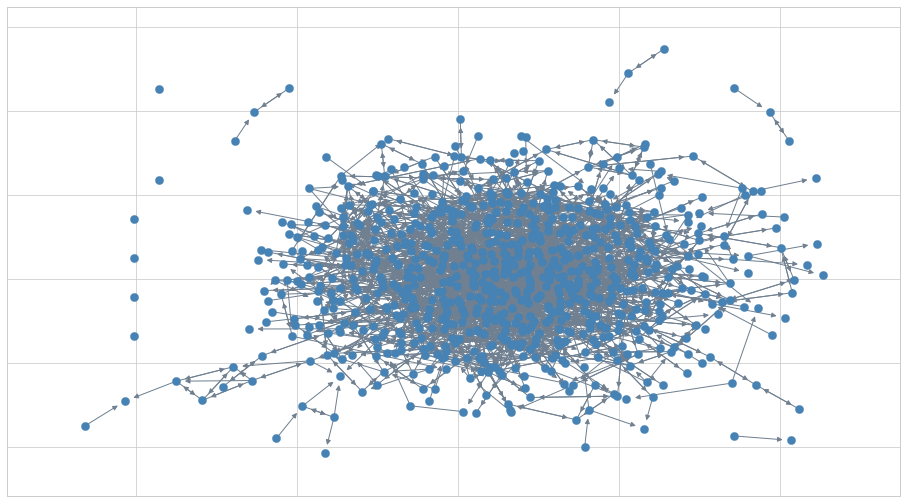

In [7]:
plotting.plotNeatoGraph(gca) 

/lscr_paper/allan/scripts/speclib/plotting.py:173: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


(<matplotlib.figure.Figure at 0x7fdcc1a9f400>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fdcc1a9fef0>)

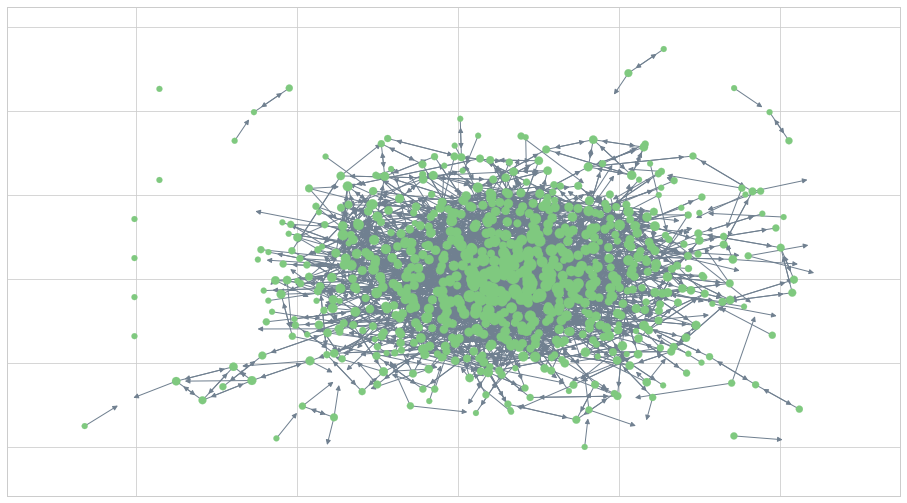

In [8]:
plotting.plotNeatoGraph(gca, plot_settings={'node_color': colorcycle[0]}, labels=None,
                        node_size=[np.sqrt(len(gca[el]))*35 for el in gca.nodes()])

In [9]:
ser = pd.Series({us: len(gca[us]) for us in gca.nodes()})

In [10]:
ser.min() 

0

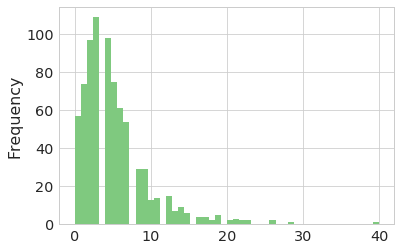

In [11]:
ser.plot.hist(50)

In [12]:
ica = graph.networkx2igraph(gca, labels=False)

In [13]:
ica.vs['label'] = ['' for el in ica.vs]
# gg.es['weight'] = adjmat[adjmat.nonzero()] 

In [14]:
shades_of_green = ['rgb(199, 231, 199)',
                   'rgb(163, 216, 163)',
                   'rgb(127, 201, 127)',
                   'rgb(91, 186, 91)',
                   'rgb(67, 159, 67)',
                   'rgb(52, 123, 52)']
ica.vs['color'] = np.random.choice(shades_of_green, size=len(ica.vs)).tolist() 

In [15]:
ica.vs['size'] = [np.sqrt(el)*3 for el in ica.indegree()]

In [16]:
ica.is_directed()

True

In [17]:
print(*list(gca.nodes_with_selfloops()), sep='\t')

u0083	u0614	u0697	u0919	u0020	u0662	u0675	u0068	u0437	u0525	u0800	u0212	u0291	u0307	u0434	u0435	u0512	u0534	u0553	u0704	u0886	u0896	u0984	u1012	u0087	u1009	u0055	u0142	u0204	u0249	u0715	u0917	u0449	u0650	u0764	u0300	u0873	u0938	u0118	u0388	u0530	u0093	u0775	u0789	u0798	u0962	u0451	u0647	u0773	u0173	u0854	u0210	u0260	u0482	u0536	u0571	u0819	u0104	u0709	u0537	u0551	u0570	u0687	u0931	u0717	u0998	u0017	u0550	u0872	u0995	u0047	u0500	u0612	u0683	u0881	u0936	u0576	u0777	u0556	u0693	u0778	u0410	u0758	u0029	u0595	u0933	u0009	u0578	u0746	u0901	u0424	u0137	u0532	u0593	u0828	u0847	u0095	u0007	u0795	u0343	u0590	u0808	u0407	u0659	u0721	u0874	u0038	u0361	u0376	u0466	u0848	u0844	u0045	u0012	u0970	u0117	u0769	u0116	u0708	u0750	u0812	u0350	u0631	u0837	u1027	u0371	u0264	u0591	u0952	u0682	u0843	u0059	u0842	u0354	u0681	u0099	u0107	u0444	u0636	u0239	u0692	u1037	u0527	u0640	u0946	u0546	u0011	u0016	u0382	u0549	u0341	u0898	u0158	u0270	u0109	u0431	u0864	u0159	u0493	u0673	u0275	u0003	u0132	u0351	u0799	u0228	u009

![https://assets-cdn.github.com/images/icons/emoji/unicode/1f53a.png](https://assets-cdn.github.com/images/icons/emoji/unicode/1f53a.png) **<font color="crimson">For some reason Igraph can't plot weighted graphs, but it can do unweighted graphs, which can be styled using the weighted attributes.</font>**

In [18]:
ica_ud = ica.as_undirected() 

In [19]:
ica_ud.is_directed() 

False

In [ ]:
layouts = [el for el in dir(ica_ud) if (el.startswith('layout_') and '3d' not in el)]
for lay in layouts:
    try:
        numlay = getattr(ica_ud, lay)()
        ig.plot(ica_ud, f'layouts/{lay}.pdf', layout=numlay)
    except:
        print(f"Failed for {lay}.") 

In [ ]:
layouts

In [20]:
gca_ud = graph.nxDiGraph2Graph(gca)

Do this on degree instead!

In [21]:
np.random.seed(113)
keep_for_plot = list()
for node in gca.nodes:
    degree = gca.degree(node)
    in_degree = gca.in_degree(node)
    out_degree = gca.out_degree(node)
    if degree < 10:
        if np.random.rand() >= 0.95:
            keep_for_plot.append(node)
    else:
        keep_for_plot.append(node) 

In [22]:
len(keep_for_plot)

345

In [23]:
len(gca.nodes)

775

In [24]:
gca_plot_d = gca.subgraph(keep_for_plot)

In [25]:
ica_plot_d = graph.networkx2igraph(gca_plot, labels=['' for _ in gca_plot_d.nodes])

NameError: name 'gca_plot' is not defined

In [ ]:
ica_plot_d.vs['size'] = [np.sqrt(el)*4 for el in ica_plot_d.indegree()] 

In [ ]:
ica_plot = ica_plot_d.as_undirected() 

In [ ]:
color_idx = np.floor((np.array(ica_plot.vs.degree()) - min(ica_plot.vs.degree()))/max(ica_plot.vs.degree())*len(shades_of_green)).astype(int)
ica_plot.vs['color'] = [shades_of_green[i] for i in color_idx]

In [ ]:
ica_plot.es['color'] = 'rgb(175, 175, 175)'

In [ ]:
ig.plot(ica_plot)

In [ ]:
ica2 = ig.Graph(directed=True)

attr = 'weight'
for node in gca.nodes:
    ica2.add_vertex(name=node)

for edge in gca.edges:
    u, v = edge
    attr_data = gca.get_edge_data(u, v, attr)
    ica2.add_edge(u, v, weight=attr_data[attr])

print(*ica2.es, sep='\n')

In [26]:
ica2 = graph.nx2ig(gca)